In [2]:
import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp
import searvey
from datetime import datetime, timedelta, timezone
import pygrib
import tempfile
import matplotlib.pyplot as plt


## Read one GFS Data on the Fly and Explore the Variable Names

In [2]:
s3 = s3fs.S3FileSystem(anon=True)  # Enable anonymous access to the S3 bucket

# Define the filename and the location of the GRIB2 file
bucket_name = 'noaa-gfs-bdp-pds'
key = 'gfs.20240413/12/atmos/gfs.t12z.sfluxgrbf000.grib2'
url = f"s3://{bucket_name}/{key}"

# Fetch the GRIB2 data from S3
with s3.open(url, 'rb') as f:
    grib_data = f.read()


# Save the GRIB2 data to a temporary file
with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
    tmp_file.write(grib_data)
    tmp_file.seek(0)  # Reset file pointer to the beginning
    # Read the GRIB2 data using pygrib from the temporary file
    grbs = pygrib.open(tmp_file.name)
    
    # Iterate over each message in the GRIB2 file
    for grb in grbs:
        # Extract variable name from the message
        variable_name = grb['name']
        print("Variable Name:", variable_name)

    # Close the GRIB2 file
    grbs.close()


Variable Name: Geopotential height
Variable Name: Temperature
Variable Name: Specific humidity
Variable Name: U component of wind
Variable Name: V component of wind
Variable Name: Surface pressure
Variable Name: Orography
Variable Name: Temperature
Variable Name: Soil temperature
Variable Name: Volumetric soil moisture content
Variable Name: Liquid volumetric soil moisture (non-frozen)
Variable Name: Soil temperature
Variable Name: Volumetric soil moisture content
Variable Name: Liquid volumetric soil moisture (non-frozen)
Variable Name: Soil temperature
Variable Name: Volumetric soil moisture content
Variable Name: Liquid volumetric soil moisture (non-frozen)
Variable Name: Soil temperature
Variable Name: Volumetric soil moisture content
Variable Name: Liquid volumetric soil moisture (non-frozen)
Variable Name: Soil moisture
Variable Name: Plant canopy surface water
Variable Name: Water equivalent of accumulated snow depth (deprecated)
Variable Name: Snow depth
Variable Name: unknown


## Extract the Variable names

Extract 'Surface pressure', '10 metre U wind component', '10 metre V wind component' and save them in xarray Dataset

In [31]:
# Define the variable names of interest
variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']

# Initialize empty arrays to store data
data_arrays = {var_name: [] for var_name in variable_names}

# Save the GRIB2 data to a temporary file
with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
    tmp_file.write(grib_data)
    tmp_file.seek(0)  # Reset file pointer to the beginning
    # Read the GRIB2 data using pygrib from the temporary file
    grbs = pygrib.open(tmp_file.name)
    
    # Iterate over each message in the GRIB2 file
    for grb in grbs:
        # Check if the message corresponds to one of the variables of interest
        if grb['name'] in variable_names:
           # Append data to the corresponding array
           data_arrays[grb['name']].append(grb.values)

# Close the GRIB2 file
grbs.close()

# Convert data arrays to xarray DataArrays
pressure_data = xr.DataArray(np.array(data_arrays['Surface pressure']), name='surface_pressure')
u_wind_data = xr.DataArray(np.array(data_arrays['10 metre U wind component']), name='u_wind')
v_wind_data = xr.DataArray(np.array(data_arrays['10 metre V wind component']), name='v_wind')

# Create an xarray Dataset
ds = xr.Dataset(
    data_vars={
        'surface_pressure': pressure_data,
        'u_wind': u_wind_data,
        'v_wind': v_wind_data,
    },
    coords={
        'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
        'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
    },
    attrs={
        'description': 'GRIB Data Example',
    },
)        

# Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
ds = ds.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})

ds


<xarray.Dataset> Size: 189MB
Dimensions:           (time: 1, y: 1536, x: 3072, latitude: 4718592,
                       longitude: 4718592)
Coordinates:
  * latitude          (latitude) float64 38MB 89.91 89.91 ... -89.91 -89.91
  * longitude         (longitude) float64 38MB 0.0 0.1172 0.2344 ... 359.8 359.9
Dimensions without coordinates: time, y, x
Data variables:
    surface_pressure  (time, y, x) float64 38MB 1.014e+05 ... 6.914e+04
    u_wind            (time, y, x) float64 38MB 4.66 4.66 4.66 ... -0.04 -0.02
    v_wind            (time, y, x) float64 38MB -0.48 -0.49 -0.5 ... -6.42 -6.42
Attributes:
    description:  GRIB Data Example

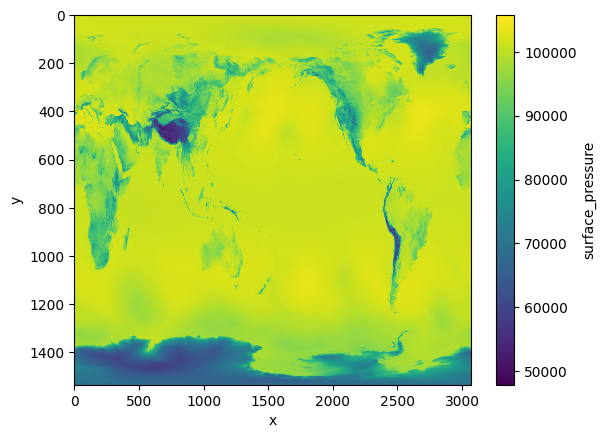

In [42]:
# Plot the surface pressure
ds['surface_pressure'].plot()
plt.gca().invert_yaxis()  # Flip the plot 

## Find all the CO-OPs stations in the subset area using searvey

In [5]:
box = (-74.5, -67, 40, 44)
bbox = shapely.box(box[0], box[2], box[1], box[3])  # Create a shapely box from the bounding box coordinates
station_ds= searvey.coops.coops_product_within_region('water_level', region=bbox, start_date='20240413')
station_ds

<xarray.Dataset> Size: 1MB
Dimensions:  (t: 3039, nos_id: 20)
Coordinates:
  * t        (t) datetime64[ns] 24kB 2024-04-13 ... 2024-04-25T15:48:00
  * nos_id   (nos_id) object 160B '8447636' '8518962' ... '8447386' '8454049'
    nws_id   (nos_id) <U5 400B 'NBFM3' 'TKPN6' 'BRHC3' ... 'FRVM3' 'QPTR1'
    x        (nos_id) float64 160B -70.91 -73.94 -73.18 ... -71.4 -71.16 -71.41
    y        (nos_id) float64 160B 41.62 42.01 41.18 41.28 ... 41.81 41.7 41.59
Data variables:
    v        (nos_id, t) float32 243kB 6.914 6.909 6.917 ... 7.892 7.86 7.838
    s        (nos_id, t) float32 243kB 0.006 0.008 0.008 ... 0.014 0.008 0.01
    f        (nos_id, t) object 486kB '1,0,0,0' '1,0,0,0' ... '0,0,0,0'
    q        (nos_id, t) object 486kB 'p' 'p' 'p' 'p' 'p' ... 'p' 'p' 'p' 'p'

## Extract the Forcing Data at Each Station Location

In [64]:
# Initialize empty DataFrames to store wind and pressure data
u_wind_df = pd.DataFrame()
v_wind_df = pd.DataFrame()
surface_pressure_df = pd.DataFrame()

# Loop over the elements of station_ds['y'] and station_ds['x']
for y_val, x_val, nos_id in zip(station_ds['y'], station_ds['x'], station_ds['nos_id']):
    # Adjust target_longitude to be in the range of 0 to 360
    longitude_adjusted = int(x_val) + 360 if int(x_val) < 0 else int(x_val)

    # Find the index of the nearest latitude and longitude in the dataset
    lat_idx = np.where((np.abs(ds['latitude'][0:4718592:3072] - int(y_val))) == np.min(np.abs(ds['latitude'][0:4718592:3072] - int(y_val))))
    lon_idx = np.where((np.abs(ds['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds['longitude'][0:3072] - longitude_adjusted)))
    
    # Extract the forcing data using the index
    u_wind_value = ds.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
    v_wind_value = ds.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
    surface_pressure_value = ds.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values

    # Append the values to the respective DataFrames as columns with NOS ids as column names
    u_wind_df[int(nos_id)] = [np.round(u_wind_value,2)]
    v_wind_df[int(nos_id)] = [np.round(v_wind_value,2)]
    surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value,2)]

# Print the resulting DataFrames
surface_pressure_df

,8447636,8518962,8467150,8465705,8447435,8418150,8461490,8510560,8443970,8452944,8531680,8419870,8516945,8518750,8449130,8447930,8452660,8454000,8447386,8454049
0,100139.51,95926.71,99857.91,100054.71,100230.71,99806.71,100054.71,100086.71,99451.51,100086.71,100419.51,99806.71,100397.11,100419.51,100139.51,100139.51,100086.71,100086.71,100086.71,100086.71


## Using the code aboves to iterate over different files for different hours.


In [15]:
# Define the observation box
box = (-74.5, -67, 40, 44)
bbox = shapely.box(box[0], box[2], box[1], box[3])  # Create a shapely box from the bounding box coordinates
station_ds = searvey.coops.coops_product_within_region('water_level', region=bbox, start_date='20240413')

# Initialize empty DataFrames to store wind and pressure data
u_wind_dfs = pd.DataFrame()
v_wind_dfs = pd.DataFrame()
surface_pressure_dfs = pd.DataFrame()

# Loop over different files for different hours
for hour in range(0, 121, 1):  # Assuming we want to loop from 0 to 120 hours
    print(hour)
    # Define the filename and the location of the GRIB2 file
    key = f'gfs.20240413/12/atmos/gfs.t12z.sfluxgrbf{hour:03d}.grib2'
    url = f"s3://noaa-gfs-bdp-pds/{key}"

    # Fetch the GRIB2 data from S3
    s3 = s3fs.S3FileSystem(anon=True)
    with s3.open(url, 'rb') as f:
        grib_data = f.read()

    # Define the variable names of interest
    variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']

    # Initialize empty arrays to store data
    data_arrays = {var_name: [] for var_name in variable_names}

    # Save the GRIB2 data to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
        tmp_file.write(grib_data)
        tmp_file.seek(0)  # Reset file pointer to the beginning
        # Read the GRIB2 data using pygrib from the temporary file
        grbs = pygrib.open(tmp_file.name)

        # Iterate over each message in the GRIB2 file
        for grb in grbs:
            # Check if the message corresponds to one of the variables of interest
            if grb['name'] in variable_names:
                # Append data to the corresponding array
                data_arrays[grb['name']].append(grb.values)

        # Close the GRIB2 file
        grbs.close()

    # Convert data arrays to xarray DataArrays
    pressure_data = xr.DataArray(np.array(data_arrays['Surface pressure']), name='surface_pressure')
    u_wind_data = xr.DataArray(np.array(data_arrays['10 metre U wind component']), name='u_wind')
    v_wind_data = xr.DataArray(np.array(data_arrays['10 metre V wind component']), name='v_wind')

    # Create an xarray Dataset
    ds = xr.Dataset(
        data_vars={
            'surface_pressure': pressure_data,
            'u_wind': u_wind_data,
            'v_wind': v_wind_data,
        },
        coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
        },
        attrs={
            'description': 'GRIB Data Example',
        },
    )

    # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
    ds = ds.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
    # Initialize empty DataFrames to store wind and pressure data for this hour
    u_wind_df = pd.DataFrame()
    v_wind_df = pd.DataFrame()
    surface_pressure_df = pd.DataFrame()
    
    # Loop over the elements of station_ds['y'] and station_ds['x']
    for y_val, x_val, nos_id in zip(station_ds['y'], station_ds['x'], station_ds['nos_id']):
        # Adjust target_longitude to be in the range of 0 to 360
        longitude_adjusted = int(x_val) + 360 if int(x_val) < 0 else int(x_val)

        # Find the index of the nearest latitude and longitude in the dataset
        lat_idx = np.where((np.abs(ds['latitude'][0:4718592:3072] - int(y_val))) == np.min(np.abs(ds['latitude'][0:4718592:3072] - int(y_val))))
        lon_idx = np.where((np.abs(ds['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds['longitude'][0:3072] - longitude_adjusted)))

        # Extract the forcing data using the index
        u_wind_value = ds.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
        v_wind_value = ds.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
        surface_pressure_value = ds.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values

        # Append the values to the respective DataFrames as columns with NOS ids as column names
        u_wind_df[int(nos_id)] = [np.round(u_wind_value, 2)]
        v_wind_df[int(nos_id)]= [np.round(v_wind_value, 2)]
        surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value, 2)]

    u_wind_dfs = pd.concat([u_wind_dfs, u_wind_df], ignore_index=True)
    v_wind_dfs = pd.concat([v_wind_dfs, v_wind_df], ignore_index=True)
    surface_pressure_dfs = pd.concat([surface_pressure_dfs, surface_pressure_df], ignore_index=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [16]:
# Print the resulting DataFrames
u_wind_dfs

,8447636,8518962,8467150,8465705,8447435,8418150,8461490,8510560,8443970,8452944,8531680,8419870,8516945,8518750,8449130,8447930,8452660,8454000,8447386,8454049
0,6.68,5.29,8.03,9.56,3.51,-0.65,9.56,8.58,1.86,8.58,12.28,-0.65,14.27,12.28,6.68,6.68,8.58,8.58,8.58,8.58
1,7.75,5.86,9.17,11.09,4.69,-0.03,11.09,11.41,3.33,11.41,11.98,-0.03,13.39,11.98,7.75,7.75,11.41,11.41,11.41,11.41
2,9.88,6.14,9.54,9.12,5.95,1.01,9.12,10.88,5.08,10.88,11.47,1.01,13.96,11.47,9.88,9.88,10.88,10.88,10.88,10.88
3,11.08,6.44,9.89,11.12,8.58,1.16,11.12,10.06,4.61,10.06,12.19,1.16,13.70,12.19,11.08,11.08,10.06,10.06,10.06,10.06
4,12.84,6.21,9.81,11.62,9.90,1.90,11.62,10.31,5.88,10.31,12.39,1.90,14.47,12.39,12.84,12.84,10.31,10.31,10.31,10.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,-6.92,-4.10,-6.76,-11.33,-5.96,-3.71,-11.33,-8.92,-2.51,-8.92,-5.32,-3.71,-9.98,-5.32,-6.92,-6.92,-8.92,-8.92,-8.92,-8.92
117,-7.11,-3.84,-7.17,-11.17,-7.18,-4.40,-11.17,-9.77,-2.73,-9.77,-6.12,-4.40,-9.15,-6.12,-7.11,-7.11,-9.77,-9.77,-9.77,-9.77
118,-8.69,-4.17,-7.32,-10.61,-8.10,-4.69,-10.61,-9.80,-3.11,-9.80,-6.90,-4.69,-8.95,-6.90,-8.69,-8.69,-9.80,-9.80,-9.80,-9.80
119,-9.81,-4.19,-7.16,-10.64,-8.74,-4.68,-10.64,-10.69,-3.17,-10.69,-5.49,-4.68,-10.21,-5.49,-9.81,-9.81,-10.69,-10.69,-10.69,-10.69


In [17]:
# Print the resulting DataFrames
v_wind_dfs

,8447636,8518962,8467150,8465705,8447435,8418150,8461490,8510560,8443970,8452944,8531680,8419870,8516945,8518750,8449130,8447930,8452660,8454000,8447386,8454049
0,7.41,0.76,1.00,2.42,8.53,8.54,2.42,7.20,3.32,7.20,0.26,8.54,1.13,0.26,7.41,7.41,7.20,7.20,7.20,7.20
1,7.19,0.60,-0.29,2.44,8.05,8.74,2.44,6.30,3.97,6.30,-0.04,8.74,-0.57,-0.04,7.19,7.19,6.30,6.30,6.30,6.30
2,6.37,0.15,-0.36,-0.84,8.25,7.82,-0.84,4.98,1.83,4.98,0.21,7.82,-0.43,0.21,6.37,6.37,4.98,4.98,4.98,4.98
3,6.11,-0.44,-0.58,0.52,6.46,7.22,0.52,2.11,2.23,2.11,-0.53,7.22,-0.28,-0.53,6.11,6.11,2.11,2.11,2.11,2.11
4,5.89,-0.12,-0.82,0.27,6.21,7.27,0.27,3.02,0.30,3.02,-0.87,7.27,-0.90,-0.87,5.89,5.89,3.02,3.02,3.02,3.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2.66,-0.04,-0.01,0.99,1.76,-0.24,0.99,3.61,0.29,3.61,-2.12,-0.24,3.17,-2.12,2.66,2.66,3.61,3.61,3.61,3.61
117,3.18,-0.13,-0.21,1.24,1.59,-0.57,1.24,1.81,-0.09,1.81,-2.90,-0.57,2.51,-2.90,3.18,3.18,1.81,1.81,1.81,1.81
118,2.31,-0.39,-0.60,0.39,1.43,-0.46,0.39,2.18,0.21,2.18,-3.49,-0.46,1.46,-3.49,2.31,2.31,2.18,2.18,2.18,2.18
119,2.21,-0.37,-1.10,-1.45,1.53,-0.16,-1.45,1.18,0.46,1.18,-3.27,-0.16,-1.32,-3.27,2.21,2.21,1.18,1.18,1.18,1.18


In [18]:
# Print the resulting DataFrames
surface_pressure_dfs

,8447636,8518962,8467150,8465705,8447435,8418150,8461490,8510560,8443970,8452944,8531680,8419870,8516945,8518750,8449130,8447930,8452660,8454000,8447386,8454049
0,100139.51,95926.71,99857.91,100054.71,100230.71,99806.71,100054.71,100086.71,99451.51,100086.71,100419.51,99806.71,100397.11,100419.51,100139.51,100139.51,100086.71,100086.71,100086.71,100086.71
1,100116.97,95958.57,99908.97,100097.77,100188.97,99787.37,100097.77,100075.37,99440.17,100075.37,100456.17,99787.37,100385.77,100456.17,100116.97,100116.97,100075.37,100075.37,100075.37,100075.37
2,100122.48,96013.68,99952.88,100141.68,100184.88,99719.28,100141.68,100090.48,99428.08,100090.48,100485.68,99719.28,100423.28,100485.68,100122.48,100122.48,100090.48,100090.48,100090.48,100090.48
3,100086.93,96019.73,99960.53,100123.73,100122.13,99646.93,100123.73,100102.93,99374.93,100102.93,100509.33,99646.93,100426.13,100509.33,100086.93,100086.93,100102.93,100102.93,100102.93,100102.93
4,100070.46,96020.86,99961.66,100116.86,100131.26,99577.66,100116.86,100091.26,99368.06,100091.26,100523.26,99577.66,100432.06,100523.26,100070.46,100070.46,100091.26,100091.26,100091.26,100091.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,101775.14,97613.54,101205.54,101523.94,101855.14,101975.14,101523.94,101651.94,101405.54,101651.94,101146.34,101975.14,101187.94,101146.34,101775.14,101775.14,101651.94,101651.94,101651.94,101651.94
117,101739.53,97608.33,101193.93,101493.13,101830.73,101949.13,101493.13,101598.73,101387.53,101598.73,101086.73,101949.13,101134.73,101086.73,101739.53,101739.53,101598.73,101598.73,101598.73,101598.73
118,101714.28,97608.68,101184.68,101509.48,101831.08,101965.48,101509.48,101591.08,101399.08,101591.08,101059.88,101965.48,101122.28,101059.88,101714.28,101714.28,101591.08,101591.08,101591.08,101591.08
119,101727.81,97654.21,101233.41,101537.41,101838.21,102022.21,101537.41,101622.21,101427.01,101622.21,101188.61,102022.21,101137.41,101188.61,101727.81,101727.81,101622.21,101622.21,101622.21,101622.21


## Read one GFS 3-hourly Data on the Fly and Explore the Variable Names

In [13]:
s3 = s3fs.S3FileSystem(anon=True)  # Enable anonymous access to the S3 bucket

# Define the filename and the location of the GRIB2 file
bucket_name = 'noaa-gfs-bdp-pds'
key = 'gfs.20240413/12/atmos/gfs.t12z.sfluxgrbf123.grib2'
url = f"s3://{bucket_name}/{key}"

# Fetch the GRIB2 data from S3
with s3.open(url, 'rb') as f:
    grib_data = f.read()


# Save the GRIB2 data to a temporary file
with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
    tmp_file.write(grib_data)
    tmp_file.seek(0)  # Reset file pointer to the beginning
    # Read the GRIB2 data using pygrib from the temporary file
    grbs = pygrib.open(tmp_file.name)
    
    # Iterate over each message in the GRIB2 file
    for grb in grbs:
        # Extract variable name from the message
        variable_name = grb['name']
        print("Variable Name:", variable_name)

    # Close the GRIB2 file
    grbs.close()


Variable Name: Geopotential height
Variable Name: Temperature
Variable Name: Specific humidity
Variable Name: U component of wind
Variable Name: V component of wind
Variable Name: Surface pressure
Variable Name: Orography
Variable Name: Temperature
Variable Name: Soil temperature
Variable Name: Volumetric soil moisture content
Variable Name: Liquid volumetric soil moisture (non-frozen)
Variable Name: Soil temperature
Variable Name: Volumetric soil moisture content
Variable Name: Liquid volumetric soil moisture (non-frozen)
Variable Name: Soil temperature
Variable Name: Volumetric soil moisture content
Variable Name: Liquid volumetric soil moisture (non-frozen)
Variable Name: Soil temperature
Variable Name: Volumetric soil moisture content
Variable Name: Liquid volumetric soil moisture (non-frozen)
Variable Name: Soil moisture
Variable Name: Plant canopy surface water
Variable Name: Water equivalent of accumulated snow depth (deprecated)
Variable Name: Snow cover
Variable Name: Snow dep

## Extract the Variable names
Extract 'Surface pressure', '10 metre U wind component', '10 metre V wind component' and save them in xarray Dataset


In [14]:
# Define the variable names of interest
variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']

# Initialize empty arrays to store data
data_arrays = {var_name: [] for var_name in variable_names}

# Save the GRIB2 data to a temporary file
with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
    tmp_file.write(grib_data)
    tmp_file.seek(0)  # Reset file pointer to the beginning
    # Read the GRIB2 data using pygrib from the temporary file
    grbs = pygrib.open(tmp_file.name)
    
    # Iterate over each message in the GRIB2 file
    for grb in grbs:
        # Check if the message corresponds to one of the variables of interest
        if grb['name'] in variable_names:
           # Append data to the corresponding array
           data_arrays[grb['name']].append(grb.values)

# Close the GRIB2 file
grbs.close()

# Convert data arrays to xarray DataArrays
pressure_data = xr.DataArray(np.array(data_arrays['Surface pressure']), name='surface_pressure')
u_wind_data = xr.DataArray(np.array(data_arrays['10 metre U wind component']), name='u_wind')
v_wind_data = xr.DataArray(np.array(data_arrays['10 metre V wind component']), name='v_wind')

# Create an xarray Dataset
ds = xr.Dataset(
    data_vars={
        'surface_pressure': pressure_data,
        'u_wind': u_wind_data,
        'v_wind': v_wind_data,
    },
    coords={
        'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
        'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
    },
    attrs={
        'description': 'GRIB Data Example',
    },
)        

# Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
ds = ds.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})

ds

<xarray.Dataset> Size: 189MB
Dimensions:           (time: 1, y: 1536, x: 3072, latitude: 4718592,
                       longitude: 4718592)
Coordinates:
  * latitude          (latitude) float64 38MB 89.91 89.91 ... -89.91 -89.91
  * longitude         (longitude) float64 38MB 0.0 0.1172 0.2344 ... 359.8 359.9
Dimensions without coordinates: time, y, x
Data variables:
    surface_pressure  (time, y, x) float64 38MB 1.015e+05 ... 6.829e+04
    u_wind            (time, y, x) float64 38MB 1.14 1.15 1.16 ... -1.07 -1.06
    v_wind            (time, y, x) float64 38MB 6.55 6.55 6.55 ... -5.1 -5.1
Attributes:
    description:  GRIB Data Example

## Loop over 3-hourly data

Since the varibale names and dimentions are similar to hourly data, we extract the data at each station, linearly interpolate, and concatinate to the previous data

In [22]:
# Loop over different files for different hours
for hour in range(120, 184, 3):  # Assuming we want to loop from 0 to 120 hours
    print(hour)
    # Define the filename and the location of the GRIB2 file for the current hour
    key_current = f'gfs.20240413/12/atmos/gfs.t12z.sfluxgrbf{hour:03d}.grib2'
    url_current = f"s3://noaa-gfs-bdp-pds/{key_current}"

    # Fetch the GRIB2 data from S3 for the current hour
    s3_current = s3fs.S3FileSystem(anon=True)
    with s3_current.open(url_current, 'rb') as f_current:
        grib_data_current = f_current.read()

    # Define the variable names of interest
    variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']

    # Initialize empty arrays to store current data
    data_arrays_current = {var_name: [] for var_name in variable_names}

    # Save the current GRIB2 data to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
        tmp_file.write(grib_data_current)
        tmp_file.seek(0)  # Reset file pointer to the beginning
        # Read the GRIB2 data using pygrib from the temporary file
        grbs = pygrib.open(tmp_file.name)

        # Iterate over each message in the GRIB2 file
        for grb in grbs:
            # Check if the message corresponds to one of the variables of interest
            if grb['name'] in variable_names:
                # Append data to the corresponding array
                data_arrays_current[grb['name']].append(grb.values)

        # Close the GRIB2 file
        grbs.close()

    
    # Convert data arrays to xarray DataArrays for current data
    pressure_data_current = xr.DataArray(np.array(data_arrays_current['Surface pressure']), name='surface_pressure')
    u_wind_data_current = xr.DataArray(np.array(data_arrays_current['10 metre U wind component']), name='u_wind')
    v_wind_data_current = xr.DataArray(np.array(data_arrays_current['10 metre V wind component']), name='v_wind')

    # Create an xarray Dataset for current data
    ds_current = xr.Dataset(
        data_vars={
            'surface_pressure': pressure_data_current,
            'u_wind': u_wind_data_current,
            'v_wind': v_wind_data_current,
        },
        coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
        },
        attrs={
            'description': 'GRIB Data Example',
        },
    )

    # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
    ds_current = ds_current.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
    # Define the filename and the location of the GRIB2 file for the next hour
    hour_next = hour + 3  # Assuming data is available 3-hourly
    key_next = f'gfs.20240413/12/atmos/gfs.t12z.sfluxgrbf{hour_next:03d}.grib2'
    url_next = f"s3://noaa-gfs-bdp-pds/{key_next}"

    # Fetch the GRIB2 data from S3 for the next hour
    s3_next = s3fs.S3FileSystem(anon=True)
    with s3_next.open(url_next, 'rb') as f_next:
        grib_data_next = f_next.read()

    # Initialize empty arrays to store current data
    data_arrays_next = {var_name: [] for var_name in variable_names}

    # Save the current GRIB2 data to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
        tmp_file.write(grib_data_next)
        tmp_file.seek(0)  # Reset file pointer to the beginning
        # Read the GRIB2 data using pygrib from the temporary file
        grbs = pygrib.open(tmp_file.name)

        # Iterate over each message in the GRIB2 file
        for grb in grbs:
            # Check if the message corresponds to one of the variables of interest
            if grb['name'] in variable_names:
                # Append data to the corresponding array
                data_arrays_next[grb['name']].append(grb.values)

        # Close the GRIB2 file
        grbs.close()


    # Convert data arrays to xarray DataArrays for next file data
    pressure_data_next = xr.DataArray(np.array(data_arrays_next['Surface pressure']), name='surface_pressure')
    u_wind_data_next = xr.DataArray(np.array(data_arrays_next['10 metre U wind component']), name='u_wind')
    v_wind_data_next = xr.DataArray(np.array(data_arrays_next['10 metre V wind component']), name='v_wind')

    # Create an xarray Dataset for next file data
    ds_next = xr.Dataset(
        data_vars={
            'surface_pressure': pressure_data_next,
            'u_wind': u_wind_data_next,
            'v_wind': v_wind_data_next,
        },
        coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
        },
        attrs={
            'description': 'GRIB Data Example',
        },
    )

    # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
    ds_next = ds_next.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})

    # Initialize empty DataFrames to store wind and pressure data for this hour
    for hour_1 in range(1, 4, 1): 
        
        u_wind_df = pd.DataFrame()
        v_wind_df = pd.DataFrame()
        surface_pressure_df = pd.DataFrame()
    
        # Loop over the elements of station_ds['y'] and station_ds['x']
        for y_val, x_val, nos_id in zip(station_ds['y'], station_ds['x'], station_ds['nos_id']):
            # Adjust target_longitude to be in the range of 0 to 360
            longitude_adjusted = int(x_val) + 360 if int(x_val) < 0 else int(x_val)

            # Find the index of the nearest latitude and longitude in the dataset
            lat_idx = np.where((np.abs(ds_current['latitude'][0:4718592:3072] - int(y_val))) == np.min(np.abs(ds_current['latitude'][0:4718592:3072] - int(y_val))))
            lon_idx = np.where((np.abs(ds_current['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds_current['longitude'][0:3072] - longitude_adjusted)))

            # Extract the current forcing data using the index 
            u_wind_value_0 = ds_current.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            v_wind_value_0 = ds_current.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            surface_pressure_value_0 = ds_current.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values

            # Extract the next forcing data using the index 
            u_wind_value_3 = ds_next.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            v_wind_value_3 = ds_next.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            surface_pressure_value_3 = ds_next.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values
            
            # Calculate interpolation coefficient
            u_wind_coeff = (u_wind_value_3 - u_wind_value_0) / 3
            v_wind_coeff = (v_wind_value_3 - v_wind_value_0) / 3 
            surface_pressure_coeff = (surface_pressure_value_3 - surface_pressure_value_0) / 3 
                        
            # Append the values to the respective DataFrames as columns with NOS ids as column names
            u_wind_df[int(nos_id)] = [np.round(u_wind_value_0, 2)] + hour_1*u_wind_coeff
            v_wind_df[int(nos_id)]= [np.round(v_wind_value_0, 2)] + hour_1*v_wind_coeff
            surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value_0, 2)] + hour_1*surface_pressure_coeff

        u_wind_dfs = pd.concat([u_wind_dfs, u_wind_df], ignore_index=True)
        v_wind_dfs = pd.concat([v_wind_dfs, v_wind_df], ignore_index=True)
        surface_pressure_dfs = pd.concat([surface_pressure_dfs, surface_pressure_df], ignore_index=True)

120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
183


In [26]:
# Delete the last row of each DataFrame to have consistant dimention size of STOFS forecast data
u_wind_dfs = u_wind_dfs[:-1]
u_wind_dfs

,8447636,8518962,8467150,8465705,8447435,8418150,8461490,8510560,8443970,8452944,8531680,8419870,8516945,8518750,8449130,8447930,8452660,8454000,8447386,8454049
0,6.680000,5.290000,8.030000,9.560000,3.510000,-0.650000,9.560000,8.580000,1.860000,8.580000,12.280000,-0.650000,14.270000,12.280000,6.680000,6.680000,8.580000,8.580000,8.580000,8.580000
1,7.750000,5.860000,9.170000,11.090000,4.690000,-0.030000,11.090000,11.410000,3.330000,11.410000,11.980000,-0.030000,13.390000,11.980000,7.750000,7.750000,11.410000,11.410000,11.410000,11.410000
2,9.880000,6.140000,9.540000,9.120000,5.950000,1.010000,9.120000,10.880000,5.080000,10.880000,11.470000,1.010000,13.960000,11.470000,9.880000,9.880000,10.880000,10.880000,10.880000,10.880000
3,11.080000,6.440000,9.890000,11.120000,8.580000,1.160000,11.120000,10.060000,4.610000,10.060000,12.190000,1.160000,13.700000,12.190000,11.080000,11.080000,10.060000,10.060000,10.060000,10.060000
4,12.840000,6.210000,9.810000,11.620000,9.900000,1.900000,11.620000,10.310000,5.880000,10.310000,12.390000,1.900000,14.470000,12.390000,12.840000,12.840000,10.310000,10.310000,10.310000,10.310000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,10.013333,4.630000,5.843333,8.313333,9.816667,1.020000,8.313333,6.770000,3.853333,6.770000,5.783333,1.020000,6.483333,5.783333,10.013333,10.013333,6.770000,6.770000,6.770000,6.770000
182,9.046667,4.530000,5.636667,7.716667,9.583333,2.630000,7.716667,7.430000,3.656667,7.430000,5.076667,2.630000,6.046667,5.076667,9.046667,9.046667,7.430000,7.430000,7.430000,7.430000
183,8.080000,4.430000,5.430000,7.120000,9.350000,4.240000,7.120000,8.090000,3.460000,8.090000,4.370000,4.240000,5.610000,4.370000,8.080000,8.080000,8.090000,8.090000,8.090000,8.090000
184,7.766667,3.873333,4.906667,7.046667,8.690000,3.733333,7.046667,7.693333,3.200000,7.693333,4.550000,3.733333,5.673333,4.550000,7.766667,7.766667,7.693333,7.693333,7.693333,7.693333


In [27]:
v_wind_dfs = v_wind_dfs[:-1]
v_wind_dfs

,8447636,8518962,8467150,8465705,8447435,8418150,8461490,8510560,8443970,8452944,8531680,8419870,8516945,8518750,8449130,8447930,8452660,8454000,8447386,8454049
0,7.410000,0.760000,1.000000,2.420000,8.530000,8.540000,2.420000,7.200000,3.320000,7.200000,0.26,8.540000,1.130000,0.26,7.410000,7.410000,7.200000,7.200000,7.200000,7.200000
1,7.190000,0.600000,-0.290000,2.440000,8.050000,8.740000,2.440000,6.300000,3.970000,6.300000,-0.04,8.740000,-0.570000,-0.04,7.190000,7.190000,6.300000,6.300000,6.300000,6.300000
2,6.370000,0.150000,-0.360000,-0.840000,8.250000,7.820000,-0.840000,4.980000,1.830000,4.980000,0.21,7.820000,-0.430000,0.21,6.370000,6.370000,4.980000,4.980000,4.980000,4.980000
3,6.110000,-0.440000,-0.580000,0.520000,6.460000,7.220000,0.520000,2.110000,2.230000,2.110000,-0.53,7.220000,-0.280000,-0.53,6.110000,6.110000,2.110000,2.110000,2.110000,2.110000
4,5.890000,-0.120000,-0.820000,0.270000,6.210000,7.270000,0.270000,3.020000,0.300000,3.020000,-0.87,7.270000,-0.900000,-0.87,5.890000,5.890000,3.020000,3.020000,3.020000,3.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,-2.116667,-3.143333,-3.843333,-5.066667,0.156667,-3.306667,-5.066667,-4.650000,-0.733333,-4.650000,-5.12,-3.306667,-5.926667,-5.12,-2.116667,-2.116667,-4.650000,-4.650000,-4.650000,-4.650000
182,-3.433333,-3.336667,-3.636667,-5.253333,-1.666667,-2.483333,-5.253333,-4.730000,-1.146667,-4.730000,-5.59,-2.483333,-6.803333,-5.59,-3.433333,-3.433333,-4.730000,-4.730000,-4.730000,-4.730000
183,-4.750000,-3.530000,-3.430000,-5.440000,-3.490000,-1.660000,-5.440000,-4.810000,-1.560000,-4.810000,-6.06,-1.660000,-7.680000,-6.06,-4.750000,-4.750000,-4.810000,-4.810000,-4.810000,-4.810000
184,-4.753333,-3.166667,-3.503333,-5.580000,-3.250000,-2.680000,-5.580000,-5.316667,-1.653333,-5.316667,-5.84,-2.680000,-6.950000,-5.84,-4.753333,-4.753333,-5.316667,-5.316667,-5.316667,-5.316667


In [28]:
surface_pressure_dfs = surface_pressure_dfs[:-1]
surface_pressure_dfs

,8447636,8518962,8467150,8465705,8447435,8418150,8461490,8510560,8443970,8452944,8531680,8419870,8516945,8518750,8449130,8447930,8452660,8454000,8447386,8454049
0,100139.510000,95926.710000,99857.910000,100054.710000,100230.71000,99806.710000,100054.710000,100086.710000,99451.510000,100086.710000,100419.510000,99806.710000,100397.110000,100419.510000,100139.510000,100139.510000,100086.710000,100086.710000,100086.710000,100086.710000
1,100116.970000,95958.570000,99908.970000,100097.770000,100188.97000,99787.370000,100097.770000,100075.370000,99440.170000,100075.370000,100456.170000,99787.370000,100385.770000,100456.170000,100116.970000,100116.970000,100075.370000,100075.370000,100075.370000,100075.370000
2,100122.480000,96013.680000,99952.880000,100141.680000,100184.88000,99719.280000,100141.680000,100090.480000,99428.080000,100090.480000,100485.680000,99719.280000,100423.280000,100485.680000,100122.480000,100122.480000,100090.480000,100090.480000,100090.480000,100090.480000
3,100086.930000,96019.730000,99960.530000,100123.730000,100122.13000,99646.930000,100123.730000,100102.930000,99374.930000,100102.930000,100509.330000,99646.930000,100426.130000,100509.330000,100086.930000,100086.930000,100102.930000,100102.930000,100102.930000,100102.930000
4,100070.460000,96020.860000,99961.660000,100116.860000,100131.26000,99577.660000,100116.860000,100091.260000,99368.060000,100091.260000,100523.260000,99577.660000,100432.060000,100523.260000,100070.460000,100070.460000,100091.260000,100091.260000,100091.260000,100091.260000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,101304.367917,97467.567917,101348.101250,101482.501250,101228.10125,101103.834583,101482.501250,101385.434583,100917.701250,101385.434583,101717.167917,101103.834583,101627.567917,101717.167917,101304.367917,101304.367917,101385.434583,101385.434583,101385.434583,101385.434583
182,101346.265833,97514.265833,101403.332500,101542.532500,101260.93250,101154.799167,101542.532500,101439.599167,100971.332500,101439.599167,101781.465833,101154.799167,101695.065833,101781.465833,101346.265833,101346.265833,101439.599167,101439.599167,101439.599167,101439.599167
183,101388.163750,97560.963750,101458.563750,101602.563750,101293.76375,101205.763750,101602.563750,101493.763750,101024.963750,101493.763750,101845.763750,101205.763750,101762.563750,101845.763750,101388.163750,101388.163750,101493.763750,101493.763750,101493.763750,101493.763750
184,101405.841250,97577.041250,101475.707917,101618.107917,101321.04125,101252.241250,101618.107917,101510.374583,101051.707917,101510.374583,101859.707917,101252.241250,101772.241250,101859.707917,101405.841250,101405.841250,101510.374583,101510.374583,101510.374583,101510.374583


In [37]:
# Create xarray Dataset
ds = xr.Dataset(
    {
        'u_wind': (('time', 'nosid'), u_wind_dfs),
        'v_wind': (('time', 'nosid'), v_wind_dfs),
        'surface_pressure': (('time', 'nosid'), surface_pressure_dfs),
    },
    coords={'time': np.arange(186), 'nosid': station_ds['nos_id'].values},  # Adjust nosid as needed
)

# Save the xarray Dataset to a NetCDF file
ds.to_netcdf('input.nc')

In [38]:
ds

<xarray.Dataset> Size: 91kB
Dimensions:           (time: 186, nosid: 20)
Coordinates:
  * time              (time) int64 1kB 0 1 2 3 4 5 6 ... 180 181 182 183 184 185
  * nosid             (nosid) object 160B '8447636' '8518962' ... '8454049'
Data variables:
    u_wind            (time, nosid) float64 30kB 6.68 5.29 8.03 ... 7.297 7.297
    v_wind            (time, nosid) float64 30kB 7.41 0.76 1.0 ... -5.823 -5.823
    surface_pressure  (time, nosid) float64 30kB 1.001e+05 ... 1.015e+05